In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd
import seaborn as sns
import re
import os.path

import peakutils
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib import cm  
import scipy.signal as signal 
import math

## Conversion functions

In [2]:
def copynumber(conc, volume, um = True):
    if um == True:
        volume = volume/1e15
        conc1 = conc/1e6
        
        moles = conc1 * volume
        copies = moles * 6.023e23
        
        return conc
    elif um == False:
        volume = volume/1e15
        moles = conc / volume
        rate = moles / 6.023e23

        return rate


In [3]:
##converts to copies/s
##multiply by 10^6, then divide by volume in nm^3

def rate_converter(conc,V):
    conc1 = conc #/0.602214076 ## convert from uM-1 s-1 to nm^3/us
    conc2 = conc1 * 1e6 ##convert to seconds from microseconds
    nanoV = V*1e9 ##convert volume from um3 to nm3
    return conc2/nanoV ##divide by volume to get copies per second

## Plot for copynumbers

[0.16605390671738465, 308.5466987251128, 3.0576388165893325, 0.0013080428182026468, 1000, 0.007548144127883685, 336.1823261401345, 0.04810333301299435, 695.1516518099922, 0.05698665247316607, 616.4082158854, 66.45490256441938, 250.0, 1.0]
[150575.0, 0.0, 3011.5, 80.39727642375051, 0.0, 15057.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


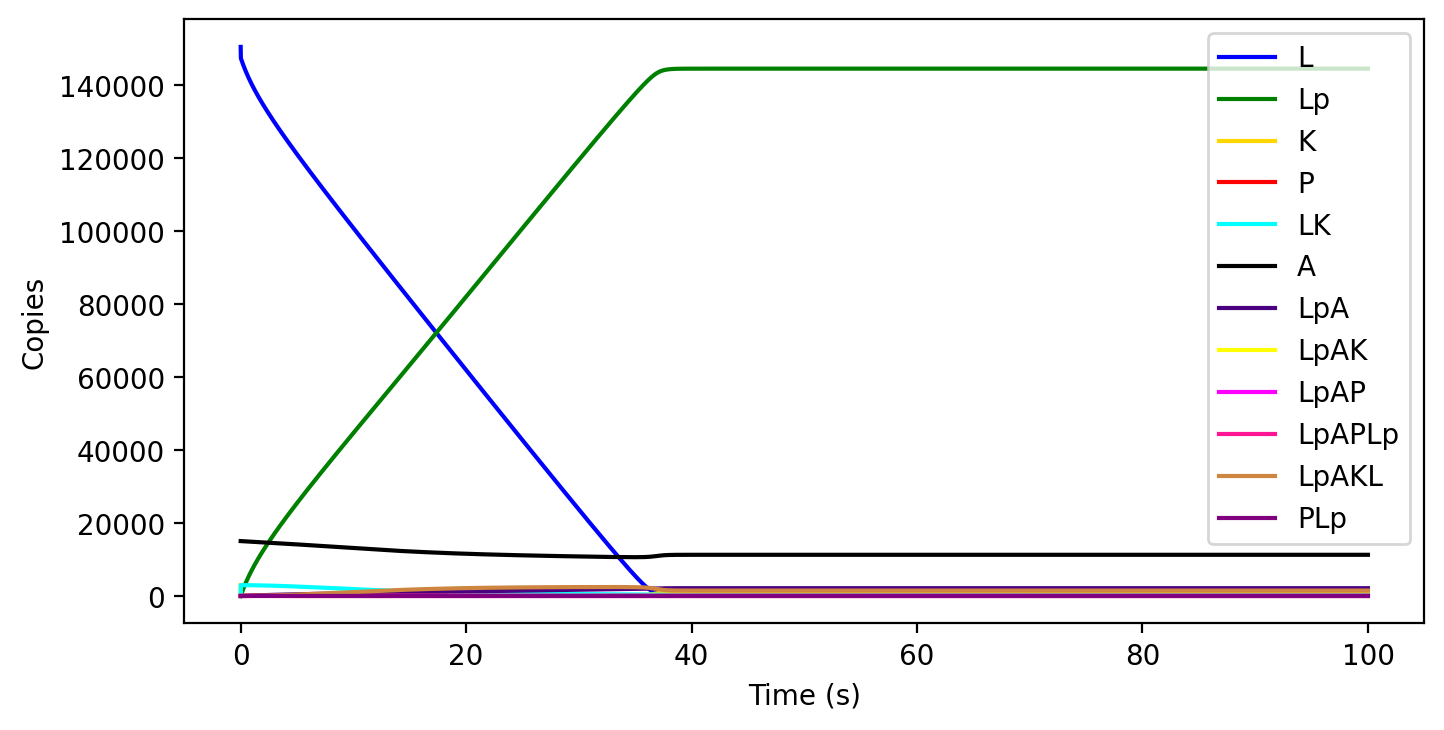

In [5]:
##['ka1: 0.2332373122294714 nm^3/us', 'kb1: 28.866668489647274 s^-1', 'kcat1: 472.7453378685757 s^-1',
## 'ka2: 72.35873714166057 nm^3/us', 'kb2: 998.1321054088311 s^-1', 'ka3: 17.029277972872272 nm^3/us',
##'kb3: 296.46075955545894 s^-1', 'ka4: 1.4853246695908338 nm^3/us', 'kb4: 5.038673916198288 s^-1',
##'ka7: 38.37021761543647 nm^3/us', 'kb7: 520.2789750962371 s^-1', 'kcat7: 260.660284096787 s^-1',
##'sigma: 1.0 nm', 'L: 4727 copies', 'Lp: 0 copies', 'K: 405 copies', 'P: 420 copies', 'LK: 0 copies',
##'A: 555 copies', 'LpA: 0 copies', 'LpAK: 0 copies', 'LpAP: 0 copies', 'LpAPLp: 0 copies',
##'LpAKL: 0 copies', 'LpP: 0 copies']


input = [0.16605390671738465, 308.5466987251128, 3.0576388165893325, 0.0013080428182026468, 1000, 0.007548144127883685, 336.1823261401345, 0.04810333301299435, 695.1516518099922, 0.05698665247316607, 
616.4082158854, 66.45490256441938, 250.0, 1.0, 150575.0, 0.0, 3011.5, 80.39727642375051, 0.0, 15057.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



# Create a timeline from 0 to 50 divided into a thousand steps
t = np.linspace(0,100,num=10000)

V = 0.092390832
VA = 1.388
sigma = 0.001
y = VA/(2*sigma)

ka1 = 0.2332373122294714
kb1 = 28.866668489647274
kcat1 = 472.7453378685757

ka2 = 72.35873714166057 
kb2 = 998.1321054088311

ka3 = 17.029277972872272
kb3 = 296.46075955545894

ka4 = 1.4853246695908338
kb4 = 5.038673916198288

ka7 = 38.37021761543647
kb7 = 520.2789750962371
kcat7 = 260.660284096787


can = [rate_converter(ka1,V), kb1, kcat1, rate_converter(ka2,V), kb2, rate_converter(ka3,V),
             kb3, rate_converter(ka4,V), kb4, rate_converter(ka7,V),kb7,kcat7, V, VA, sigma]

L = 4727   
Lp = 0 
K = 405
P = 420
LK = 0 
A = 555
LpA = 0
LpAK = 0
LpAP = 0
LpAPLp = 0
LpAKL = 0
LpP = 0


initial_populations = [copynumber(L,V),copynumber(Lp,V),copynumber(K,V),copynumber(P,V),
                        copynumber(LK,V),copynumber(A,V),copynumber(LpA,V),copynumber(LpAK,V),copynumber(LpAP,V),
                        copynumber(LpAPLp,V),copynumber(LpAKL,V),copynumber(LpP,V)]


can = input[:14]

initial_populations = input[14:]

def calculate_current_population_change_rates(current_counts, t, can):

    #V = can[12]
    VA = can[12]
    #A = V/VA
    sigma = can[13]
    #y1 = VA/(2*sigma)
    
    
    ka1 = can[0]
    kb1 = can[1]
    kcat1 = can[2]

    ka2 = can[3]
    kb2 = can[4]

    ka3 = can[5]
    kb3 = can[6]

    ka4 = can[7]
    kb4 = can[8]

    ka7 = can[9]
    kb7 = can[10]
    kcat7 = can[11]

    ka5 = can[9]
    kb5 = can[10]
    kcat5 = can[11]

    ka6 = can[0]
    kb6 = can[1]
    kcat6 = can[2]

    
    #initial conditions
    L = current_counts[0]   # make sure in uM
    Lp = current_counts[1] 
    K = current_counts[2]
    P = current_counts[3]
    LK = current_counts[4] 
    A = current_counts[5]
    LpA = current_counts[6]
    LpAK = current_counts[7]
    LpAP = current_counts[8]
    LpAPLp = current_counts[9]
    LpAKL = current_counts[10]
    LpP = current_counts[11]



    dL = (kb1*LK) - (ka1*L*K) + (kcat5*LpAPLp) + (kb6*LpAKL) - ((VA/(2*sigma))*ka6*LpAK*L) + (kcat7*LpP)
    dLp = (kcat1*LK) + (kb2*LpA) - (ka2*Lp*A) + (kb5*LpAPLp) - ((VA/(2*sigma))*ka5*Lp*LpAP) + (kcat6*LpAKL) - (ka7*Lp*P) + (kb7*LpP)
    dK = (kb1*LK) - (ka1*L*K) + (kcat1*LK) + (kb3*LpAK) - (ka3*LpA*K)
    dP = (kb4*LpAP) - (ka4*LpA*P) - (ka7*Lp*P) + (kb7*LpP) + (kcat7*LpP)
    dLK = (ka1*L*K) - (kb1*LK) - (kcat1*LK)
    dA = (kb2*LpA) - (ka2*Lp*A)
    dLpA = (ka2*Lp*A) - (kb2*LpA) + (kb3*LpAK) - (ka3*LpA*K) + (kb4*LpAP) - (ka4*LpA*P)
    dLpAK = (ka3*LpA*K) - (kb3*LpAK) + (kb6*LpAKL) - ((VA/(2*sigma))*ka6*LpAK*L) + (kcat6*LpAKL)
    dLpAP = (ka4*LpA*P) - (kb4*LpAP) + (kb5*LpAPLp) - ((VA/(2*sigma))*ka5*LpAP*Lp) + (kcat5*LpAPLp)
    dLpAPLp = ((VA/(2*sigma))*ka5*LpAP*Lp) - (kb5*LpAPLp) - (kcat5*LpAPLp)
    dLpAKL = ((VA/(2*sigma))*ka6*LpAK*L) - (kb6*LpAKL) - (kcat6*LpAKL)
    dLpP = (ka7*Lp*P) - (kb7*LpP) - (kcat7*LpP)

    return([dL, dLp, dK, dP, dLK, dA, dLpA, dLpAK, dLpAP, dLpAPLp, dLpAKL, dLpP])	

# Repeatedly calls 'calculate_current_population_change_rates' for every time step and solves numerically to get the population numbers
solutions = odeint(calculate_current_population_change_rates, initial_populations, t, args=(can,))

#solutions = solve_ivp(fun=calculate_current_population_change_rates,method='BDF', t_span=(0, 100), 
#            y0=initial_populations, t_eval=t, args=(params,),rtol=1e-6, atol=1e-9)


#Plot the two population counts over time
#########################################
fig = plt.figure(figsize=(8,4),dpi=200)

plt.plot(t,solutions[:,0], color="b", label = 'L')
plt.plot(t,solutions[:,1], color="g", label = 'Lp')
plt.plot(t,solutions[:,2], color="gold", label = 'K')
plt.plot(t,solutions[:,3], color="r", label = 'P')
plt.plot(t,solutions[:,4], color="cyan", label = 'LK')
plt.plot(t,solutions[:,5], color="black", label = 'A')
plt.plot(t,solutions[:,6], color="indigo", label = 'LpA')
plt.plot(t,solutions[:,7], color="yellow", label = 'LpAK')
plt.plot(t,solutions[:,8], color="magenta", label = 'LpAP')
plt.plot(t,solutions[:,9], color="deeppink", label = 'LpAPLp')
plt.plot(t,solutions[:,10], color="peru", label = 'LpAKL')
plt.plot(t,solutions[:,11], color="purple", label = 'PLp')

plt.xlabel('Time (s)')
plt.ylabel('Copies')
plt.legend()

print(can)
print(initial_populations)
plt.show()



In [6]:
dt = 0.001
sample_rate = 0.0033333333
samples_per_hour = (1/dt)

jump = int(samples_per_hour/(sample_rate*3600)) 
jump


83

In [7]:
T = 100
N = int(T/dt)
nS = N/jump 

In [51]:
dt = 0.001
T = 100
N = int(T/dt)
sample_rate = 1/dt #5 times per second

sample_ratio = 100

jump = int(sample_rate/sample_ratio)
#jump =1


In [9]:
def getFrequencies(y):
    #fft sample rate: 1 sample per 5 minutes
    y = y[0::jump]  
    res = abs(fft.rfft(y))
    #normalize the amplitudes 
    res = res/math.ceil(nS/2) 
    return res

In [10]:
solutions[:,5].shape

(10000,)

In [19]:
max(fftData)

1930.4434989885717

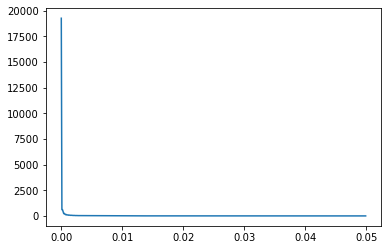

In [52]:
fftData = getFrequencies(solutions[:,5])
fftData = np.array(fftData) 


xf = fft.rfftfreq(int(N), 1/jump)

plt.plot(xf[:500], np.abs(fftData)[:500])


In [62]:
indexes = peakutils.indexes(fftData, thres=0.2/max(fftData), min_dist=1) 
indexes

array([ 5,  8, 11, 13, 16, 19, 22, 24, 27, 30, 32, 35, 38, 40, 43, 46, 49,
       51, 54, 57, 62, 65, 73])

In [64]:
indexes = peakutils.indexes(fftData, thres=np.mean(fftData), min_dist=10, thres_abs = True) 
indexes

array([ 5, 16])

In [22]:
indexes = peakutils.indexes(solutions[:,5], thres=2000/max(solutions[:,5]), min_dist=1) 
len(indexes)

14

In [26]:
indexes = peakutils.indexes(solutions[:,5], thres=0.2, min_dist=1) 
len(indexes)

0

In [27]:
indexes = peakutils.indexes(solutions[:,5], thres=np.mean(solutions[:,5]), min_dist=1, thres_abs = True) 
len(indexes)

0

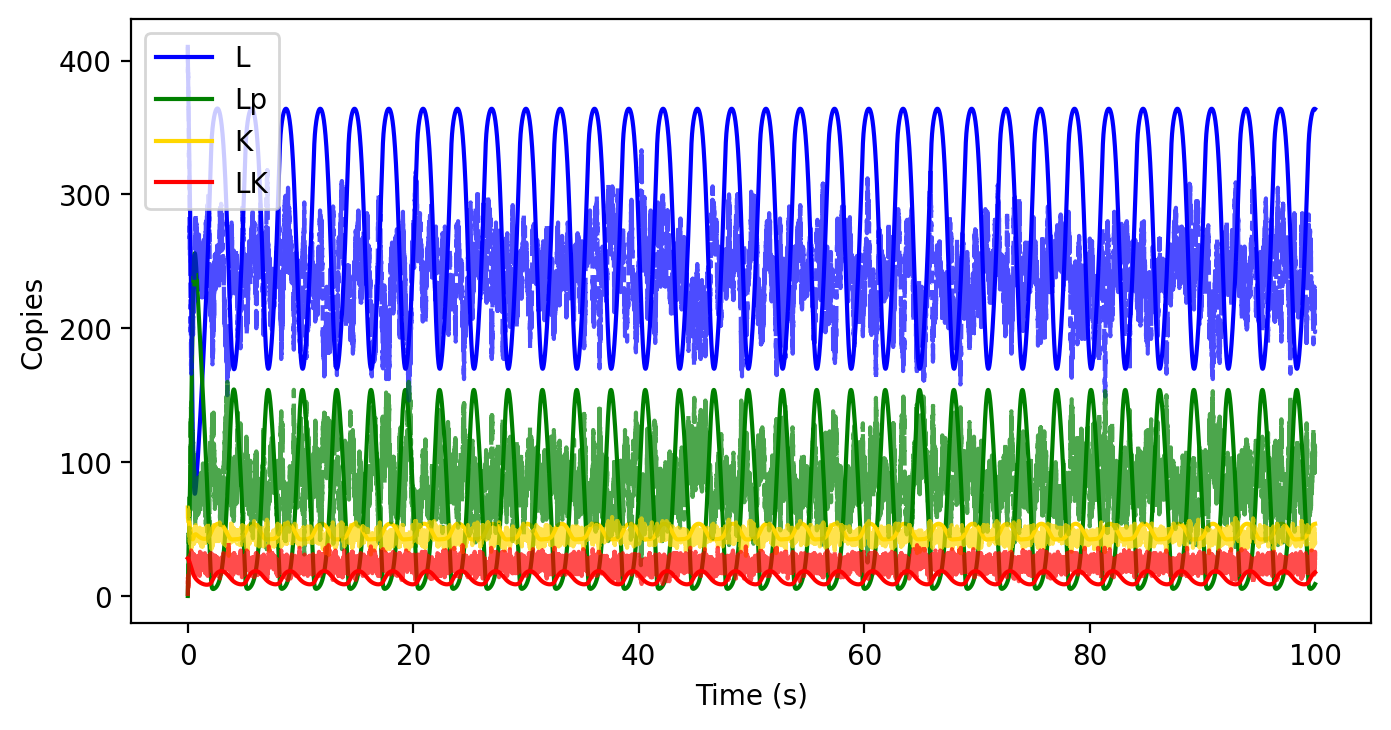

In [29]:
fig = plt.figure(figsize=(8,4),dpi=200)

plt.plot(t,solutions[:,0], color="b", label = 'L')
plt.plot(t,solutions[:,1], color="g", label = 'Lp')
plt.plot(t,solutions[:,2], color="gold", label = 'K')
plt.plot(t,solutions[:,3], color="r", label = 'LK')

plt.plot(df['Time (s)'], df['pip2(head~U)'], color = 'b', linestyle = 'dashed', alpha = 0.7)
plt.plot(df['Time (s)'], df['pip2(head~P)'], color = 'g', linestyle = 'dashed', alpha = 0.7)
plt.plot(df['Time (s)'], df['kin(ap)'], color = 'gold', linestyle = 'dashed', alpha = 0.7)
plt.plot(df['Time (s)'], df['kin(pi!1).pip2(head~U!1)'], color = 'r', linestyle = 'dashed', alpha = 0.7)


plt.xlabel('Time (s)')
plt.ylabel('Copies')
plt.legend()


In [5]:
def concentration(copies, V):

    moles = copies/6.023e17 #converts copies to micromoles
    V = V/1e15 #convert volume in um^-3 to liters
    conc = moles/V #divide micromoles by volume
    
    return conc


In [6]:
def df_pretty(df, V):
    newdf = pd.DataFrame()
    newdf['Time (us)'] = df['Time (s)'].apply(lambda x: x*1e6)
    newdf['PIP'] = df.iloc[:,1].apply(lambda copies: concentration(copies, V))
    newdf['PIP2'] = df.iloc[:,2].apply(lambda copies: concentration(copies, V))
    ##newdf['A'] = df.iloc[:,3].apply(lambda copies: concentration(copies, V))
    #newdf['A'] = (df['ap2(m2muh)'][0] - df.iloc[:,9] - df.iloc[:,11] - df.iloc[:,13])
    newdf['K'] = df[['kin(ap)','kin(pi)']].min(axis=1)
    newdf['K'] = newdf['K'].apply(lambda copies: concentration(copies, V))
    newdf['P'] = df[['syn(ap)','syn(pi)']].min(axis=1)
    newdf['P'] = newdf['P'].apply(lambda copies: concentration(copies, V))
    newdf['LK'] = df['kin(pi!1).pip2(head~U!1)'] - df['kin(ap!1).ap2(sy!1)']
    newdf['LK'] = newdf['LK'].apply(lambda copies: concentration(copies, V))
    newdf['LpP'] = df['syn(pi!1).pip2(head~P!1)'] - df['syn(ap!1).ap2(sy!1)']
    newdf['LpP'] = newdf['LpP'].apply(lambda copies: concentration(copies, V))
    newdf['A'] = df[['ap2(m2muh)','ap2(sy)']].min(axis=1)
    newdf['A'] = newdf['A'].apply(lambda copies: concentration(copies, V))

    ## difference between LpA and AK or AP because enzyme can only bind LpA
    newdf['LpA'] = df['pip2(head~P!1).ap2(m2muh!1)'] - df['kin(ap!1).ap2(sy!1)'] - df['syn(ap!1).ap2(sy!1)']
    newdf['LpA'] = newdf['LpA'].apply(lambda copies: concentration(copies, V))

    newdf['LpAK'] = df['kin(ap!1).ap2(sy!1)']
    newdf['LpAK'] = newdf['LpAK'].apply(lambda copies: concentration(copies, V))

    newdf['LpAP'] = df['syn(ap!1).ap2(sy!1)']
    newdf['LpAP'] = newdf['LpAP'].apply(lambda copies: concentration(copies, V))

    #newdf['LpAPLp'] = df['syn(ap!1).ap2(sy!1)']
    #newdf['LpAPLp'] = newdf['LpAPLp'].apply(lambda copies: concentration(copies, V))
    

    return newdf 


In [7]:
newdf = df_pretty(df, V)

In [8]:
newdf

,Time (us),PIP,PIP2,K,P,LK,LpP,A,LpA,LpAK,LpAP
0,0.0,87.182899,0.000000,7.094112,5.434670,0.000000,0.000000,9.977391,0.000000,0.000000,0.000000
1,500.0,87.182899,0.000000,7.094112,5.434670,0.000000,0.000000,9.977391,0.000000,0.000000,0.000000
2,1000.0,87.162156,0.020743,7.094112,5.434670,0.000000,0.000000,9.977391,0.000000,0.000000,0.000000
3,1500.0,87.162156,0.020743,7.094112,5.434670,0.000000,0.000000,9.977391,0.000000,0.000000,0.000000
4,2000.0,87.162156,0.020743,7.094112,5.434670,0.000000,0.000000,9.977391,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
199996,99998000.0,75.359380,3.401855,6.119190,1.078637,-0.124458,-1.182352,4.646436,-0.933436,0.974922,4.356034
199997,99998500.0,75.421609,3.339626,6.181419,1.078637,-0.124458,-1.244581,4.708665,-0.746749,0.912693,4.356034
199998,99999000.0,75.359380,3.215168,6.139933,1.057894,-0.062229,-1.244581,4.646436,-0.746749,0.954179,4.376777
199999,99999500.0,75.359380,3.381112,6.098447,1.057894,-0.145201,-1.286067,4.604950,-0.871207,0.995665,4.376777


In [52]:
os.path.dirname(__file__)

NameError: name '__file__' is not defined

Text(0, 0.5, 'Concentration (uM)')

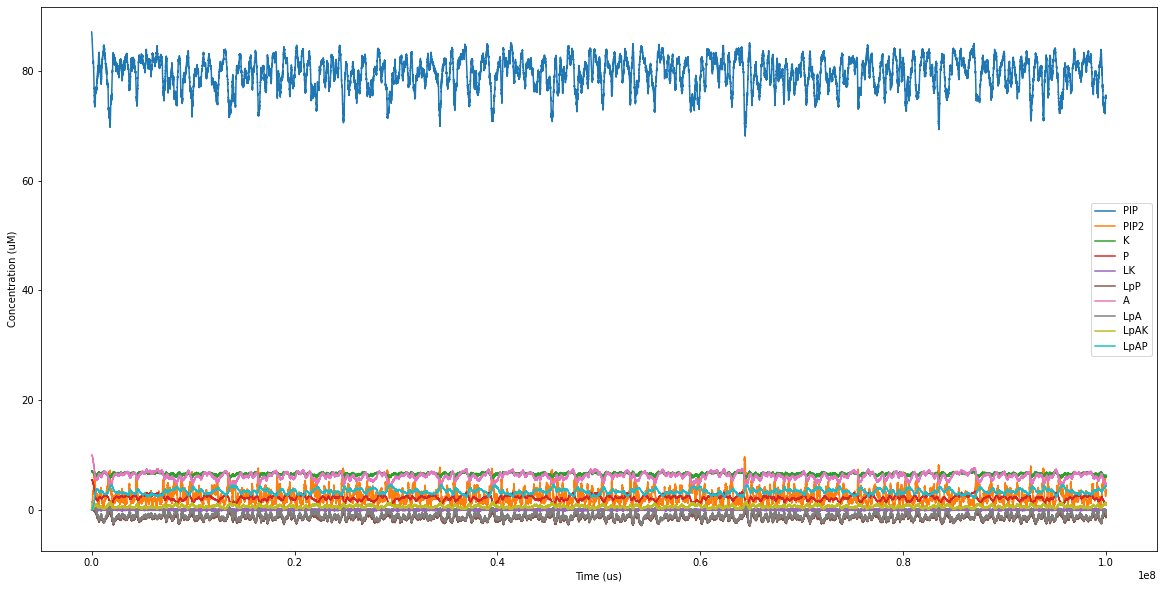

In [9]:
ax = newdf.plot.line(x = 'Time (us)', figsize=(20,10))
ax.set_ylabel('Concentration (uM)')
